In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linucb import LinUCB, eLinUCB, HybridLinUCB
import os
from tqdm.auto import tqdm
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

%matplotlib inline

# Load Data

In [2]:
print(os.listdir("./datasets"))

dfs = []
for fname in os.listdir("./datasets"):
    print(fname)
    df = pd.read_csv(f"./datasets/{fname}", engine='python', low_memory=True)
    dfs.append(df)

['users.csv', 'movies.csv', 'ratings.csv']
users.csv
movies.csv
ratings.csv


In [3]:
users, movies, ratings = dfs
display(users.head())
print(f"="*35)
display(movies.head())
print(f"="*35)
display(ratings.head())

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


,movieid,title,genre
0,1,Toy Story (1995),"Animation, Children's, Comedy"
1,2,Jumanji (1995),"Adventure, Children's, Fantasy"
2,3,Grumpier Old Men (1995),"Comedy, Romance"
3,4,Waiting to Exhale (1995),"Comedy, Drama"
4,5,Father of the Bride Part II (1995),Comedy


,userid,movieid,ratings,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


# Preprocess

## Users

In [4]:
## gender one-hot
users['gender'] = users['gender'].map(lambda x: 1 if x == "F" else 0)
users.head()

,userid,gender,age,occupation,zipcode
0,1,1,1,10,48067
1,2,0,56,16,70072
2,3,0,25,15,55117
3,4,0,45,7,02460
4,5,0,25,20,55455


In [5]:
## age one-hot
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']
labels = [i for i in range(len(names))]

name_label = dict()
for name, label in zip(names, labels):
    name_label[name] = label

print(name_label)
users['agegroup'] = pd.cut(users['age'], bins=bins, labels=names)
users['agegroup'] = users['agegroup'].map(name_label)
users.head()

{'<20': 0, '20-29': 1, '30-39': 2, '40-49': 3, '51-60': 4, '60+': 5}


,userid,gender,age,occupation,zipcode,agegroup
0,1,1,1,10,48067,0
1,2,0,56,16,70072,4
2,3,0,25,15,55117,1
3,4,0,45,7,02460,3
4,5,0,25,20,55455,1


In [6]:
users.drop('age', axis=1, inplace=True)

age_onehot = np.zeros(shape=(users.shape[0], users['agegroup'].nunique()), dtype=np.uint8)
for i in range(users.shape[0]):
    group_idx = users['agegroup'].iloc[i]
    age_onehot[i][group_idx] = 1

for j in range(users['agegroup'].nunique()):
    users[f"agegroup_{j}"] = age_onehot[:, j]

users.drop('agegroup', axis=1, inplace=True)
users.head()

,userid,gender,occupation,zipcode,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4
0,1,1,10,48067,1,0,0,0,0
1,2,0,16,70072,0,0,0,0,1
2,3,0,15,55117,0,1,0,0,0
3,4,0,7,02460,0,0,0,1,0
4,5,0,20,55455,0,1,0,0,0


In [7]:
## occupation one-hot
occupation_onehot = np.zeros(shape=(users.shape[0], users['occupation'].nunique()), dtype=np.uint8)
for i in range(users.shape[0]):
    group_idx = users['occupation'].iloc[i]
    occupation_onehot[i][group_idx] = 1

for j in range(users['occupation'].nunique()):
    users[f"occupation_{j}"] = occupation_onehot[:, j]

users.drop('occupation', axis=1, inplace=True)
users.head()

,userid,gender,zipcode,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,1,1,48067,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,70072,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,0,55117,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,0,02460,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,55455,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
## drop zipcode
users.drop('zipcode', axis=1, inplace=True)
users.head()

,userid,gender,agegroup_0,agegroup_1,agegroup_2,agegroup_3,agegroup_4,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Movies

In [9]:
## drop title
movies.drop('title', axis=1, inplace=True)

In [10]:
genres = []
for i in range(movies.shape[0]):
    genre_string = movies['genre'].iloc[i]
    genre_split = genre_string.split(', ')
    for g in genre_split:
        if g not in genres:
            genres.append(g)
genres = sorted(genres)
print(genres)

['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [11]:
## genre one-hot
genre_onehot = np.zeros(shape=(movies.shape[0], len(genres)), dtype=np.uint8)
for i in range(movies.shape[0]):
    g_split = movies['genre'].iloc[i].split(', ')
    for g in g_split:
        idx = genres.index(g)
        genre_onehot[i, idx] = 1

for j in range(len(genres)):
    genre_name = genres[j]
    movies[f"is_{genre_name}"] = genre_onehot[:, j]

movies.drop('genre', axis=1, inplace=True)
movies.head()

,movieid,is_Action,is_Adventure,is_Animation,is_Children's,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Fantasy,is_Film-Noir,is_Horror,is_Musical,is_Mystery,is_Romance,is_Sci-Fi,is_Thriller,is_War,is_Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Ratings

In [12]:
ratings.drop('timestamp', axis=1, inplace=True)

In [13]:
user_mean = ratings[['userid', 'ratings']].groupby(by='userid').mean()
user_mean.reset_index(drop=False, inplace=True)
user_mean.head()

,userid,ratings
0,1,4.188679
1,2,3.713178
2,3,3.901961
3,4,4.190476
4,5,3.146465


In [14]:
ratings = pd.merge(left=ratings, right=user_mean, on='userid', how='left')
ratings.head()

,userid,movieid,ratings_x,ratings_y
0,1,1193,5,4.188679
1,1,661,3,4.188679
2,1,914,3,4.188679
3,1,3408,4,4.188679
4,1,2355,5,4.188679


In [15]:
ratings['reward'] = (ratings['ratings_x'] > ratings['ratings_y']).astype(np.uint8)
ratings.drop(['ratings_x', 'ratings_y'], axis=1, inplace=True)
print(ratings.shape)
ratings.head()

(1000209, 3)


,userid,movieid,reward
0,1,1193,1
1,1,661,0
2,1,914,0
3,1,3408,0
4,1,2355,1


In [16]:
n = 30

top_movies = ratings[["movieid", "userid"]].groupby(by="movieid").count().sort_values(by=["userid"], ascending=False)
top_movies.reset_index(drop=False, inplace=True)
top_movies.head()
top_n_movies = movies[movies['movieid'].isin(top_movies.head(n)['movieid'])]
top_n_movies.sort_values(by='movieid', inplace=True)
top_n_movies.reset_index(drop=True, inplace=True)
top_n_movies.head()

,movieid,is_Action,is_Adventure,is_Animation,is_Children's,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Fantasy,is_Film-Noir,is_Horror,is_Musical,is_Mystery,is_Romance,is_Sci-Fi,is_Thriller,is_War,is_Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,110,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,260,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,296,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,318,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [17]:
top_n_ratings = ratings[ratings['movieid'].isin(top_n_movies['movieid'])]
top_n_ratings.reset_index(drop=True, inplace=True)
print(top_n_ratings.shape)
top_n_ratings.head()

(73972, 3)


,userid,movieid,reward
0,1,1197,0
1,1,1270,1
2,1,527,1
3,1,1097,0
4,1,2762,0


# LinUCB Simulation

In [18]:
def run(learner, data, arms, users, nsim):
    arm_features = arms.shape[1]
    user_features = users.shape[1] - 1
    d = arm_features + user_features
    
    aligned_ctr = []
    aligned_timestep = 0
    cum_reward = 0
    
    arm_list = arms['movieid']
    for sim in range(nsim):
        if sim == 0:
            data = data.copy()
            unused = []
        else:
            data = data.iloc[unused].copy()
            unused = []
        cnt = data.shape[0]
        for i in tqdm(range(data.shape[0])):
            user_id = data['userid'].iloc[i]
            movie_id = data['movieid'].iloc[i]
            user_feature = users[users['userid'] == user_id].iloc[:, 1:].to_numpy()
            chosen_arm = learner.choose(user_feature)
            if arm_list[chosen_arm] == movie_id:
                reward = data['reward'].iloc[i]
                learner.update(user_feature, chosen_arm, reward)

                aligned_timestep += 1
                cum_reward += reward
                aligned_ctr.append((cum_reward / aligned_timestep))
            else:
                unused.append(i)
        print(f"Hit count: {cnt - len(unused)}")
    
    return {
        "aligned_ctr": aligned_ctr,
        "aligned_timestamp": aligned_timestep,
        "cum_reward": cum_reward,
    }

In [19]:
arm_to_use = top_n_movies.iloc[:, 1:].to_numpy()
arm_features = movies.shape[1] - 1
user_features = users.shape[1] - 1
d = arm_features + user_features
k = arm_features * user_features
alpha = 2.
reward_mean = top_n_ratings["reward"].mean()
print(f"Mean reward: {reward_mean}")

Mean reward: 0.7467960850051371


  0%|          | 0/73972 [00:00<?, ?it/s]

Hit count: 3318


  0%|          | 0/70654 [00:00<?, ?it/s]

Hit count: 2975


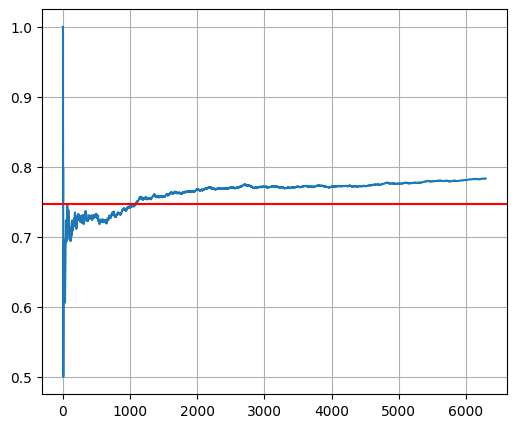

In [20]:
result_linucb = run(
    learner=LinUCB(arms=arm_to_use, d=d, alpha=alpha), 
    data=top_n_ratings, 
    arms=top_n_movies,
    users=users,
    nsim=2
)

plt.figure(figsize=(6, 5))
plt.plot(result_linucb['aligned_ctr'])
plt.axhline(y=reward_mean, color="red")
plt.grid(True)

plt.show()

  0%|          | 0/73972 [00:00<?, ?it/s]

Hit count: 3096


  0%|          | 0/70876 [00:00<?, ?it/s]

Hit count: 2685


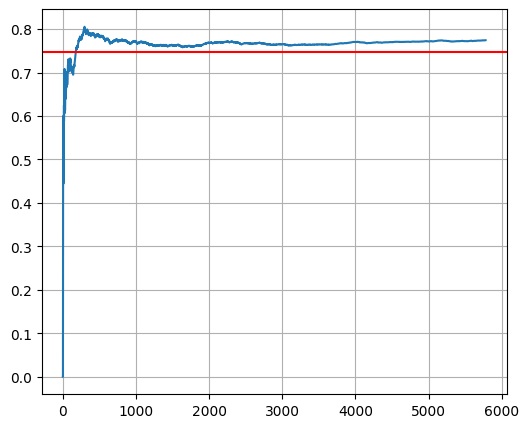

In [21]:
result_elinucb = run(
    learner=eLinUCB(arms=arm_to_use, d=d, alpha=alpha, epsilon=0.1), 
    data=top_n_ratings, 
    arms=top_n_movies,
    users=users,
    nsim=2
)

plt.figure(figsize=(6, 5))
plt.plot(result_elinucb['aligned_ctr'])
plt.axhline(y=reward_mean, color="red")
plt.grid(True)

plt.show()

In [20]:
result_hlinucb = run(
    learner=HybridLinUCB(arms=arm_to_use, d=d, k=k, alpha=alpha), 
    data=top_n_ratings, 
    arms=top_n_movies,
    users=users,
    nsim=2
)

plt.figure(figsize=(6, 5))
plt.plot(result_linucb['aligned_ctr'])
plt.axhline(y=reward_mean, color="red")
plt.grid(True)

plt.show()

  0%|          | 0/73972 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(aligned_ctr)
# plt.axhline(y=reward_mean, color = "red")
# plt.title(f"alpha = {alpha}")
# plt.grid(True)
# plt.show()